In [58]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [59]:
WINDOW_SIZE = 120
BATCH_SIZE = 1
N_EPOCHS = 10
PATH = 'data/sunspots.csv'

In [60]:
def load_data(path):
    df = pd.read_csv(path)
    df.columns = ['x', 'date', 'monthly_mean_sunspots']
    df = df.set_index('date')
    df = df['monthly_mean_sunspots']
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df.asfreq('ME')
    return df

df = load_data(PATH)

time = df.index
series = df.values

In [61]:
test_size = 800
val_size = 200

train_val_series, train_val_time = series[:-test_size], time[:-test_size]
test_series, test_time = series[-test_size:], time[-test_size:]

train_series, train_time = train_val_series[:-val_size], train_val_time[:-val_size]
val_series, val_time = train_val_series[-val_size:], train_val_time[-val_size:]
 
train_series = train_series.reshape((len(train_series), 1))
val_series = val_series.reshape((len(val_series), 1))
test_series  = test_series.reshape((len(test_series), 1))

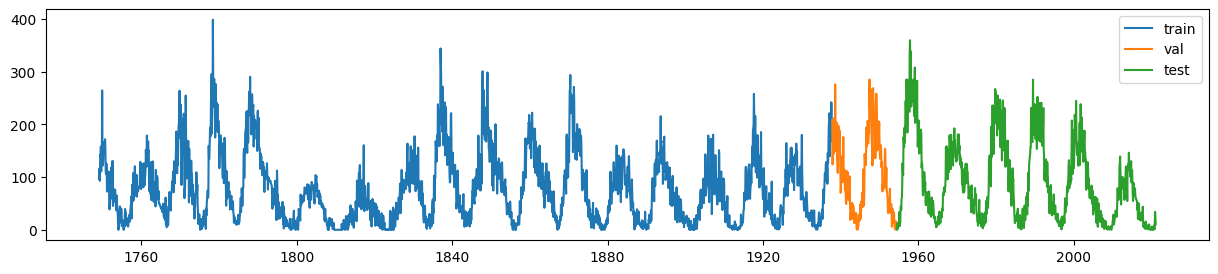

In [62]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(train_time, train_series, label='train')
ax.plot(val_time, val_series, label='val')
ax.plot(test_time, test_series, label='test')
ax.legend()
plt.show()

In [63]:
train_generator = TimeseriesGenerator(
    train_series, 
    train_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

val_generator = TimeseriesGenerator(
    val_series, 
    val_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

test_generator = TimeseriesGenerator(
    test_series, 
    test_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.LSTM(2, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [65]:
history = model.fit(train_generator, validation_data=val_generator, epochs=N_EPOCHS, verbose=1)

Epoch 1/10
   6/2145 ━━━━━━━━━━━━━━━━━━━━ 57s 27ms/step - loss: 11641.0947 

c:\Users\RobertoTatisMuvdi\venvs\.ml\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2145/2145 ━━━━━━━━━━━━━━━━━━━━ 68s 31ms/step - loss: 8473.7012 - val_loss: 8203.8301
Epoch 2/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - loss: 1933.5978 - val_loss: 1951.2174
Epoch 3/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - loss: 1009.9150 - val_loss: 821.3532
Epoch 4/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - loss: 725.5850 - val_loss: 821.8546
Epoch 5/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 106s 49ms/step - loss: 731.6642 - val_loss: 856.4525
Epoch 6/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - loss: 753.8467 - val_loss: 818.9556
Epoch 7/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 111s 52ms/step - loss: 866.2671 - val_loss: 822.0038
Epoch 8/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - loss: 741.6174 - val_loss: 862.7619
Epoch 9/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - loss: 723.0317 - val_loss: 829.2800
Epoch 10/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 72s 33ms/step - loss: 725.8484 - val_loss: 817.1227


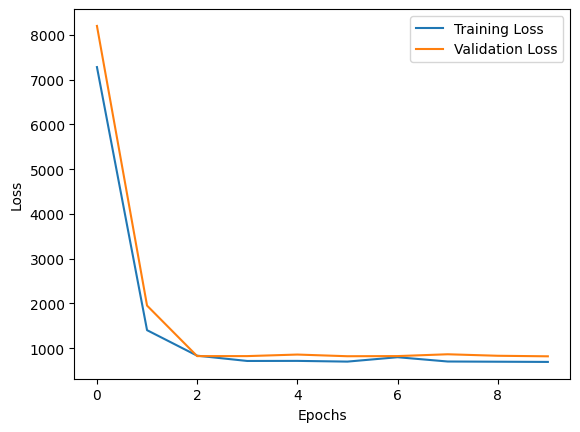

In [66]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

In [67]:
test_predictions = model.predict(test_generator)
train_predictions = model.predict(train_generator)
val_predictions = model.predict(val_generator)

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 


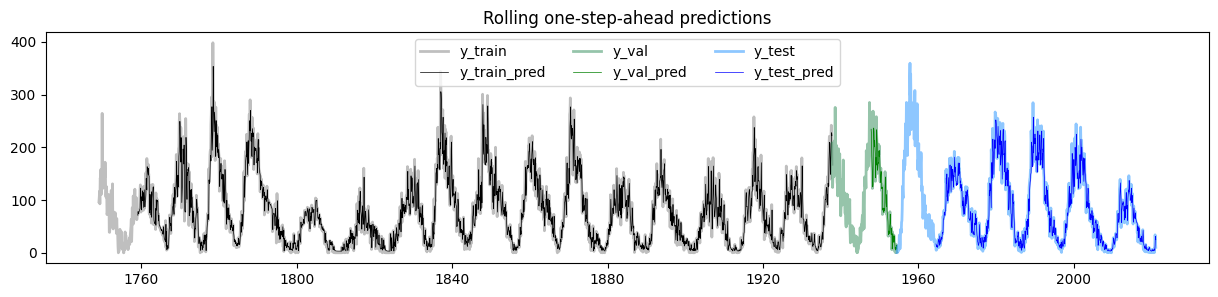

In [69]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(train_time, train_series, color='gray', linewidth=2, alpha=0.5, label='y_train')
ax.plot(train_time[WINDOW_SIZE:], train_predictions, color='black', linewidth=0.5, label='y_train_pred')
ax.plot(val_time, val_series, color='seagreen', linewidth=2, alpha=0.5, label='y_val')
ax.plot(val_time[WINDOW_SIZE:], val_predictions, color='green', linewidth=0.5, label='y_val_pred')
ax.plot(test_time, test_series, color='dodgerblue', linewidth=2, alpha=0.5, label='y_test')
ax.plot(test_time[WINDOW_SIZE:], test_predictions, color='blue', linewidth=0.5, label='y_test_pred')
ax.legend(ncol=3)
ax.set_title('Rolling one-step-ahead predictions')
plt.show()